In [8]:
import pandas as pd 
df = pd.read_csv("data/ldw_2023_pilot_coding_tasks_outputs_processed_2.csv")

## Learning Task 1

In [9]:
robotarm_df = df[df['Activity Name'] == 'RobotArm']
robotarm_l1 = robotarm_df[robotarm_df['Activity ID'] == "P1M120"]
key_vector_l1 = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,ra-world-shape ra-world-shapeA,', 'E,E,E,E,ra-world-shape ra-world-shapeA,false']"

In [10]:
robotarm_l1_grouped = robotarm_l1.groupby('Student ID').apply(lambda x: 1 in x['WorldspaceScore'].values)

# separate the students into two groups
success_students_l1 = robotarm_l1_grouped[robotarm_l1_grouped == True].index
failure_students_l1 = robotarm_l1_grouped[robotarm_l1_grouped == False].index

In [11]:
robotarm_l1_success = robotarm_l1[robotarm_l1['Student ID'].isin(success_students_l1)]
robotarm_l1_failure = robotarm_l1[robotarm_l1['Student ID'].isin(failure_students_l1)]

In [12]:
# for each student, sort the rows by timestamp
robotarm_l1_success = robotarm_l1_success.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='timestamp')).reset_index(drop=True)
# drop rows where WorldSpace is Null
robotarm_l1_success = robotarm_l1_success.dropna(subset=['WorldSpace'])

robotarm_l1_success['index'] = robotarm_l1_success.groupby('Student ID').cumcount()

In [13]:
nb_student = len(robotarm_l1_success['Student ID'].unique())
print(f"Number of students: {nb_student}")

Number of students: 263


In [14]:
# compute the Euclidean distance between the key vector and the student's worldspace vector
from distances import * 

robotarm_l1_success['euclidean_distance'] = robotarm_l1_success['WorldSpace'].apply(lambda x: euclidean(x, key_vector_l1))

TypeError: euclidean() missing 1 required positional argument: 'initial_distance'

### Overview

In [488]:
total_students_l1 = len(robotarm_l1['Student ID'].unique())
print(f"Number of students who attempted the task: {total_students_l1}")

Number of students who attempted the task: 386


In [489]:
total_success_students_l1 = len(robotarm_l1_success['Student ID'].unique())
print(f"Number of students who successfully completed the task: {total_success_students_l1}")

Number of students who successfully completed the task: 263


In [490]:
data = robotarm_l1_success[["Student ID", "WorldSpace", "index", "euclidean_distance"]]

In [491]:
len(data['index'].unique())

22

In [492]:
initial_worldspace = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,false']"
initial_distance = euclidean(initial_worldspace, key_vector_l1)

# dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
index_dict = {i: i+1 for i in range(len(data['index'].unique()))}

data['index'] = data['index'].apply(lambda x: index_dict[x])

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_5601/1022690241.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['index'] = data['index'].apply(lambda x: index_dict[x])


In [493]:
# for each student, add a new row with the initial worldspace and distance
initial_data = pd.DataFrame({'Student ID': data['Student ID'].unique(), 'WorldSpace': initial_worldspace, 'index': 0, 'euclidean_distance': initial_distance})

# append the initial data to the dataframe
data = pd.concat([data, initial_data])

# group the data by Student ID and sort by index
data = data.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

In [494]:
data['index normalized'] = data['index'] / data.groupby('Student ID')['index'].transform('max')

In [495]:
data.describe()

,index,euclidean_distance,index normalized
count,1483.000000,1483.000000,1483.00000
mean,3.290627,0.372550,0.50000
std,3.321884,0.252495,0.35117
min,0.000000,0.000000,0.00000
25%,1.000000,0.000000,0.20000
50%,2.000000,0.468521,0.50000
75%,5.000000,0.624695,0.80000
max,22.000000,0.624695,1.00000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


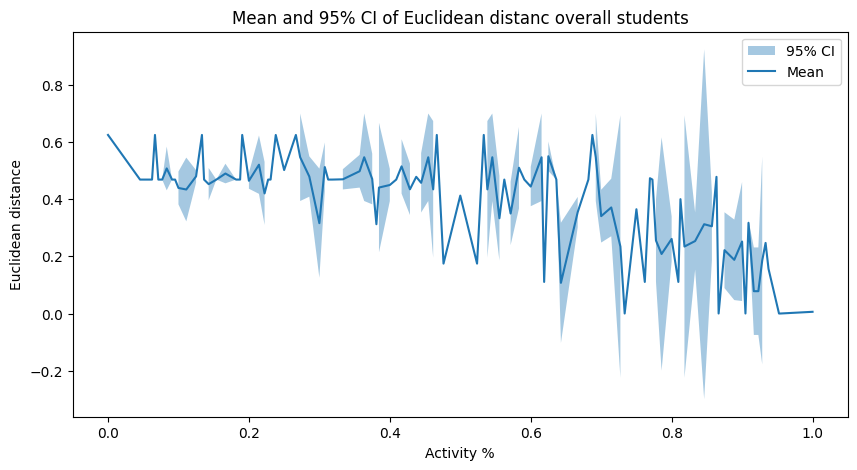

In [496]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# plot one figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))


grouped = data.groupby("index normalized")

# Calculate mean and 95% CI for "Jaro bars" metric
mean_values_bars = grouped["euclidean_distance"].mean()
ci_values_bars = grouped["euclidean_distance"].apply(lambda x: stats.sem(x, nan_policy='omit') * 1.96)  # 95% CI

# Fill between upper and lower CI
ax.fill_between(mean_values_bars.index, mean_values_bars - ci_values_bars, mean_values_bars + ci_values_bars, alpha=0.4, label="95% CI")

ax.plot(mean_values_bars.index, mean_values_bars, linestyle='-', label="Mean")
ax.set_xlabel("Activity %")
ax.set_ylabel("Euclidean distance")
ax.set_title("Mean and 95% CI of Euclidean distanc overall students")
ax.legend()

plt.show()

### Let's cluster to see the different behaviors evolution 

In [497]:
data = robotarm_l1_success[["Student ID", "index", "euclidean_distance"]]

pivot_data = data.pivot(index='Student ID', columns='index', values='euclidean_distance')

features = pivot_data.agg(['mean', 'std'], axis=1)

features.dropna(inplace=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

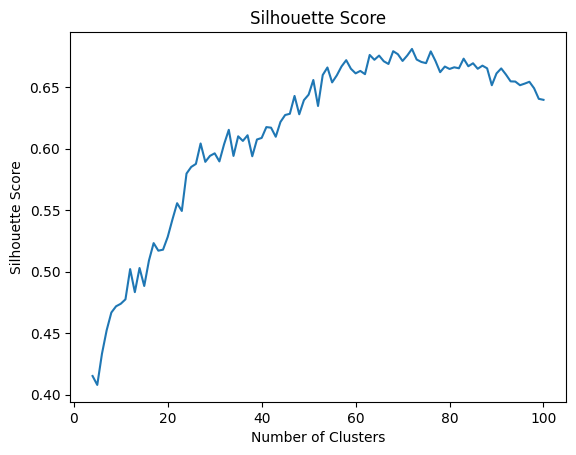

Optimal number of clusters based on silhouette score: 72


In [498]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)


max_clusters = 100

# Silhouette score
sil_scores = []
for i in range(4, max_clusters+1):
    kmeans = KMeans(n_clusters=i)
    cluster_labels = kmeans.fit_predict(normalized_features)
    sil_scores.append(silhouette_score(normalized_features, cluster_labels))

plt.plot(range(4, max_clusters+1), sil_scores)
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()
    
optimal_clusters_silhouette = np.argmax(sil_scores) + 4
print("Optimal number of clusters based on silhouette score:", optimal_clusters_silhouette)


In [499]:
optimal_kmeans = KMeans(n_clusters=optimal_clusters_silhouette)

cluster_labels = optimal_kmeans.fit_predict(normalized_features)

features['cluster'] = cluster_labels

features.reset_index(inplace=True)
features

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Student ID,mean,std,cluster
0,AUS123001,0.256186,0.217114,21
1,AUS123073,0.429478,0.295632,20
2,AUS123433,0.000000,0.000000,0
3,AUS123505,0.306822,0.221909,16
4,AUS123649,0.364405,0.325102,33
...,...,...,...,...
227,UK123004,0.336676,0.244370,55
228,UK123010,0.156174,0.220863,14
229,UK123019,0.263494,0.239670,10
230,UK123022,0.326964,0.255533,1


### Find the medoids 

In [500]:
cluster_groups = features.groupby('cluster').agg({'Student ID': 'unique', 'mean': 'median', 'std': 'median'}).reset_index()

In [501]:
cluster_groups

,cluster,Student ID,mean,std
0,0,"[AUS123433, AUS214473, AUS512089, AUS791640, B...",0.000000,0.000000
1,1,"[AUS128218, AUS184840, UK123022]",0.317154,0.255091
2,2,"[AUS128686, AUS163039, AUS184220, AUS214149, A...",0.234261,0.331295
3,3,"[BGR163147, COL821173]",0.525671,0.232938
4,4,[AUS891716],0.093704,0.209529
...,...,...,...,...
67,67,[COL163075],0.315552,0.312397
68,68,"[AUS214437, AUS512773]",0.354455,0.171629
69,69,"[AUS214805, AUS512665]",0.330201,0.274615
70,70,"[AUS184508, NOR512125]",0.382890,0.286589


In [502]:
def find_student_medoid(df, student_list, median_mean, median_std): 
    list_score = []
    
    for student in student_list: 
        mean_student = df[df['Student ID'] == student]['mean'].values[0]
        std_student = df[df['Student ID'] == student]['std'].values[0]
        
        score = abs(mean_student - median_mean) + abs(std_student - median_std)
        list_score.append(score)
    
    return np.argmin(list_score)

In [503]:
student_medoids = []

for cluster in range(optimal_clusters_silhouette): 
    students = cluster_groups[cluster_groups['cluster'] == cluster]['Student ID'].values[0]
    print("Cluster : ", cluster)
    if len(students) == 1: 
        student_medoid = students[0]
        print(student_medoid)
    else:
        mean = cluster_groups[cluster_groups['cluster'] == cluster]['mean'].values[0]
        std = cluster_groups[cluster_groups['cluster'] == cluster]['std'].values[0]
        print(students)
        print(mean)
        print(std)
        
        student_index = find_student_medoid(features, students, mean, std)
        student_medoid = cluster_groups[cluster_groups['cluster'] == cluster]['Student ID'].values[0][student_index]
        print(student_medoid)
    student_medoids.append(student_medoid)


Cluster :  0
['AUS123433' 'AUS214473' 'AUS512089' 'AUS791640' 'BGR128038' 'BGR512125'
 'BGR751242' 'BGR791028' 'BGR951107' 'NOR214185' 'NOR821065' 'UK123001']
0.0
0.0
AUS123433
Cluster :  1
['AUS128218' 'AUS184840' 'UK123022']
0.3171539909428023
0.2550910685264956
AUS128218
Cluster :  2
['AUS128686' 'AUS163039' 'AUS184220' 'AUS214149' 'AUS416697' 'AUS512853'
 'AUS791100' 'AUS821173' 'AUS821605' 'AUS914429' 'AUS914717' 'AUS951431'
 'AUS951575' 'BGR512233' 'BGR951071' 'COL416013' 'NOR163183' 'NOR821209']
0.2342606428329091
0.3312945782245396
AUS128686
Cluster :  3
['BGR163147' 'COL821173']
0.525670905530489
0.2329384244131324
BGR163147
Cluster :  4
AUS891716
Cluster :  5
['AUS184652' 'AUS184796' 'AUS416193']
0.34358227615493336
0.32006096980144877
AUS184652
Cluster :  6
['AUS751242' 'AUS891608']
0.3734274433277484
0.18658739598012808
AUS891608
Cluster :  7
['AUS128146' 'AUS791208' 'AUS891752' 'BGR163111' 'BGR184184' 'BGR951035'
 'COL163003' 'NOR214005']
0.31234752377721214
0.441726104299

In [504]:
features['student_medoid'] = np.nan

for cluster, medoid in enumerate(student_medoids):
    features.loc[features['cluster'] == cluster, 'student_medoid'] = medoid

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_5601/3087065301.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'AUS123433' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  features.loc[features['cluster'] == cluster, 'student_medoid'] = medoid


In [505]:
features

,Student ID,mean,std,cluster,student_medoid
0,AUS123001,0.256186,0.217114,21,AUS123001
1,AUS123073,0.429478,0.295632,20,AUS123073
2,AUS123433,0.000000,0.000000,0,AUS123433
3,AUS123505,0.306822,0.221909,16,AUS416229
4,AUS123649,0.364405,0.325102,33,AUS123649
...,...,...,...,...,...
227,UK123004,0.336676,0.244370,55,UK123004
228,UK123010,0.156174,0.220863,14,AUS128362
229,UK123019,0.263494,0.239670,10,AUS128074
230,UK123022,0.326964,0.255533,1,AUS128218


In [506]:
def distance_to_medoid(df, student1, student2): 
    mean_1 = df[df['Student ID'] == student1]['mean'].values[0]
    mean_2 = df[df['Student ID'] == student2]['mean'].values[0]
    
    return np.abs(mean_1 - mean_2)

In [507]:
for idx, row in features.iterrows(): 
    student_id = row['Student ID']
    student_medoid = row['student_medoid']
    
    features.loc[idx, "distance_medoid"] = distance_to_medoid(features, student_id, student_medoid)

In [508]:
features

,Student ID,mean,std,cluster,student_medoid,distance_medoid
0,AUS123001,0.256186,0.217114,21,AUS123001,0.000000
1,AUS123073,0.429478,0.295632,20,AUS123073,0.000000
2,AUS123433,0.000000,0.000000,0,AUS123433,0.000000
3,AUS123505,0.306822,0.221909,16,AUS416229,0.007928
4,AUS123649,0.364405,0.325102,33,AUS123649,0.000000
...,...,...,...,...,...,...
227,UK123004,0.336676,0.244370,55,UK123004,0.000000
228,UK123010,0.156174,0.220863,14,AUS128362,0.004806
229,UK123019,0.263494,0.239670,10,AUS128074,0.000000
230,UK123022,0.326964,0.255533,1,AUS128218,0.009810


### Plot the clusters

Graph with 232 nodes and 160 edges


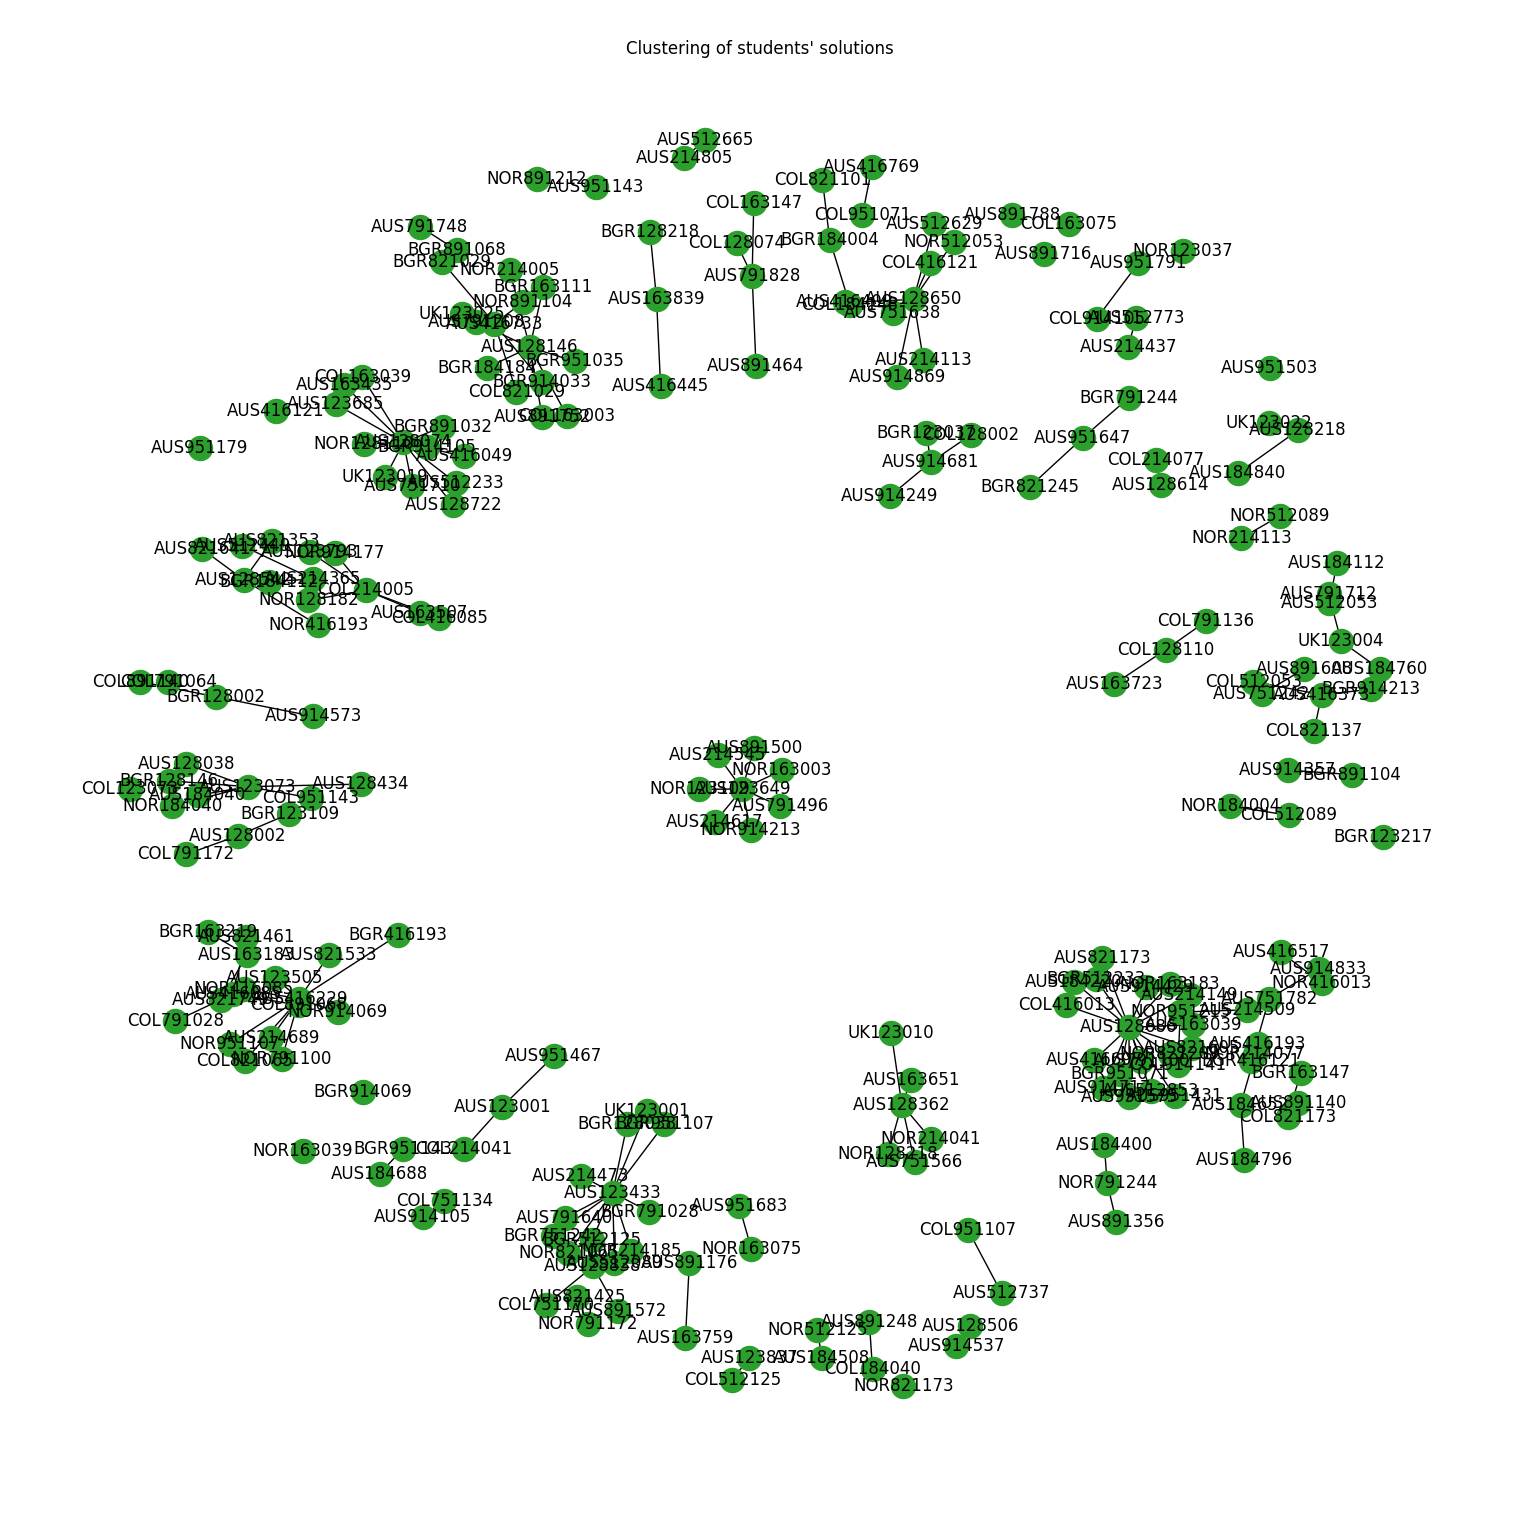

In [509]:
import networkx as nx
from itertools import combinations

G = nx.Graph()
edges = []
node_color = dict()
edges_length= dict()

for student in features['Student ID'].values:
    G.add_node(student)
    student_attr_medoid = features[features['Student ID'] == student]['student_medoid'].values[0]
    if student != student_attr_medoid:
        edges.append((student, student_attr_medoid))
        edges_length[(student, student_attr_medoid)] = (features[features['Student ID'] == student]['distance_medoid'].values[0])*0.001

G.add_edges_from(edges)
print(G)
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.13 )  # Seed layout for reproducibility seed=3929279
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color="tab:green",
)
plt.suptitle("Clustering of students' solutions")
plt.show()

In [510]:
# compute silhouette score for each medoid
sample_silhouette_values = silhouette_samples(normalized_features, cluster_labels)
silhouette_scores_clusters = []
for label in range(optimal_clusters_silhouette):
    silhouette_scores_clusters.append(sample_silhouette_values[cluster_labels == label].mean())


In [511]:
# create a dataframe with the silhouette scores of each cluster and the number of students in each cluster
silhouette_df = pd.DataFrame({'cluster': range(optimal_clusters_silhouette), 'silhouette_score': silhouette_scores_clusters, 'nb_students': features.groupby('cluster').size()})

In [512]:
silhouette_df

,cluster,silhouette_score,nb_students
cluster,,,
0,0,1.000000,12
1,1,0.704887,3
2,2,1.000000,18
3,3,0.431781,2
4,4,0.000000,1
...,...,...,...
67,67,0.000000,1
68,68,0.362973,2
69,69,0.794125,2


In [513]:
# remove rows with only one student
silhouette_df = silhouette_df[silhouette_df['nb_students'] > 1]

In [514]:
# sort the clusters by number of students
silhouette_df = silhouette_df.sort_values(by='nb_students', ascending=False)

In [515]:
# sort the clusters by silhouette score
silhouette_df = silhouette_df.sort_values(by='silhouette_score', ascending=False)
silhouette_df

,cluster,silhouette_score,nb_students
cluster,,,
2,2,1.000000,18
13,13,1.000000,3
22,22,1.000000,3
5,5,1.000000,3
25,25,1.000000,2
60,60,1.000000,2
63,63,1.000000,3
64,64,1.000000,2
35,35,1.000000,4


### Analysis medoid 2

In [516]:
# get the students in the best cluster
best_cluster = silhouette_df.iloc[0]['cluster']
best_cluster_students = features[features['cluster'] == best_cluster]['Student ID'].values

In [517]:
best_cluster_students

array(['AUS128686', 'AUS163039', 'AUS184220', 'AUS214149', 'AUS416697',
       'AUS512853', 'AUS791100', 'AUS821173', 'AUS821605', 'AUS914429',
       'AUS914717', 'AUS951431', 'AUS951575', 'BGR512233', 'BGR951071',
       'COL416013', 'NOR163183', 'NOR821209'], dtype=object)

In [518]:
# keep row of students in the best cluster in robotarm_l1_success
robotarm_l1_success_medoid_2 = robotarm_l1_success[robotarm_l1_success['Student ID'].isin(best_cluster_students)]

In [519]:
robotarm_l1_success_medoid_2['WorldSpace'].values[0]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,ra-world-shape ra-world-shapeA,E,E,E,', 'E,ra-world-shape ra-world-shapeA,E,E,E,false']"

In [520]:
# create new dataframe with column Student ID, WorldSpace, index normalized, index and euclidean_distance
data_medoid_2 = robotarm_l1_success_medoid_2[["Student ID", "WorldSpace", "index", "euclidean_distance"]]

In [521]:
initial_worldspace = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,false']"
initial_distance = euclidean(initial_worldspace, key_vector_l1)

# dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
index_dict = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}

data_medoid_2['index'] = data_medoid_2['index'].apply(lambda x: index_dict[x])


/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_5601/1103190968.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_medoid_2['index'] = data_medoid_2['index'].apply(lambda x: index_dict[x])


In [522]:
# for each student, add a new row with the initial worldspace and distance
initial_data = pd.DataFrame({'Student ID': best_cluster_students, 'WorldSpace': initial_worldspace, 'index': 0, 'euclidean_distance': initial_distance})

# append the initial data to the dataframe
data_medoid_2 = pd.concat([data_medoid_2, initial_data])

# group the data by Student ID and sort by index
data_medoid_2 = data_medoid_2.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

In [523]:
data_medoid_2['index normalized'] = data_medoid_2['index'] / data_medoid_2.groupby('Student ID')['index'].transform('max')

In [524]:
data_medoid_2.describe()

,index,euclidean_distance,index normalized
count,54.000000,54.000000,54.000000
mean,1.000000,0.364405,0.500000
std,0.824163,0.267937,0.412082
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.468521,0.500000
75%,2.000000,0.624695,1.000000
max,2.000000,0.624695,1.000000


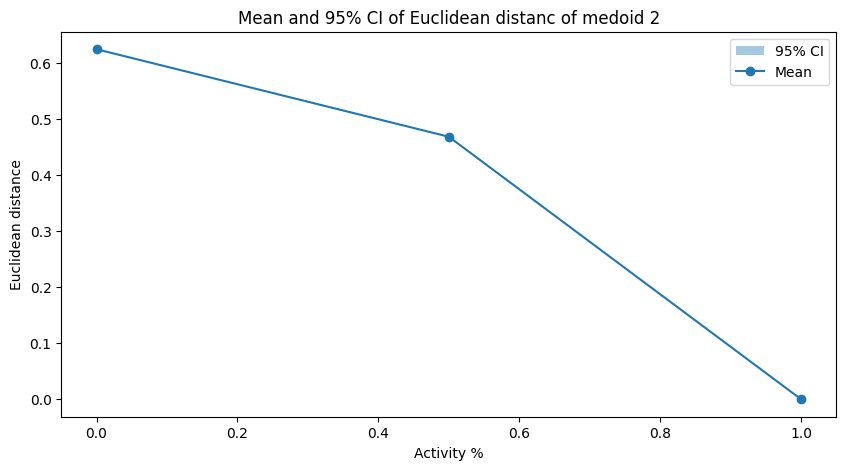

In [526]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# plot one figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))


grouped = data_medoid_2.groupby("index normalized")

# Calculate mean and 95% CI for "Jaro bars" metric
mean_values_bars = grouped["euclidean_distance"].mean()
ci_values_bars = grouped["euclidean_distance"].apply(lambda x: stats.sem(x, nan_policy='omit') * 1.96)  # 95% CI

# Fill between upper and lower CI
ax.fill_between(mean_values_bars.index, mean_values_bars - ci_values_bars, mean_values_bars + ci_values_bars, alpha=0.4, label="95% CI")

ax.plot(mean_values_bars.index, mean_values_bars, marker='o', linestyle='-', label="Mean")
ax.set_xlabel("Activity %")
ax.set_ylabel("Euclidean distance")
ax.set_title("Mean and 95% CI of Euclidean distanc of medoid 2")
ax.legend()

plt.show()

In [527]:
data_medoid_2['WorldSpace'].values[1]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,ra-world-shape ra-world-shapeA,E,E,E,', 'E,ra-world-shape ra-world-shapeA,E,E,E,false']"

In [528]:
preprocess(data_medoid_2['WorldSpace'].values[1])

array([['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'A', 'E', 'E', 'E'],
       ['E', 'A', 'E', 'E', 'E']], dtype='<U1')

In [531]:
def analysis_medoid(df, features, medoid, initial_worldspace, key_vector): 
    cluster_student = features[features['cluster'] == medoid]['Student ID'].values
    
    df_medoid = df[df['Student ID'].isin(cluster_student)]
    
    df_medoid = df_medoid[["Student ID", "WorldSpace", "index", "euclidean_distance"]]
    
    initial_distance = euclidean(initial_worldspace, key_vector)

    # dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
    index_dict = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12}

    df_medoid['index'] = df_medoid['index'].apply(lambda x: index_dict[x])

    # for each student, add a new row with the initial worldspace and distance
    initial_data = pd.DataFrame({'Student ID': cluster_student, 'WorldSpace': initial_worldspace, 'index': 0, 'euclidean_distance': initial_distance})

    # append the initial data to the dataframe
    df_medoid = pd.concat([df_medoid, initial_data])

    # group the data by Student ID and sort by index
    df_medoid = df_medoid.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)
    
    df_medoid['index normalized'] = df_medoid['index'] / df_medoid.groupby('Student ID')['index'].transform('max')
    
    return df_medoid


def plot_medoid_distance(df, title): 
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    grouped = df.groupby("index normalized")

    # Calculate mean and 95% CI for "Jaro bars" metric
    mean_values_bars = grouped["euclidean_distance"].mean()
    ci_values_bars = grouped["euclidean_distance"].apply(lambda x: stats.sem(x, nan_policy='omit') * 1.96)  # 95% CI

    # Fill between upper and lower CI
    ax.fill_between(mean_values_bars.index, mean_values_bars - ci_values_bars, mean_values_bars + ci_values_bars, alpha=0.4, label="95% CI")

    ax.plot(mean_values_bars.index, mean_values_bars, marker='o', linestyle='-', label="Mean")
    ax.set_xlabel("Activity %")
    ax.set_ylabel("Euclidean distance")
    ax.set_title(title)
    ax.legend()

    plt.show()

In [532]:
key_vector_l1 = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,ra-world-shape ra-world-shapeA,', 'E,E,E,E,ra-world-shape ra-world-shapeA,false']"

initial_vector = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,false']"

In [534]:
df_medoid_0 = analysis_medoid(robotarm_l1_success, features, 0, initial_vector, key_vector_l1)

In [535]:
df_medoid_0

,Student ID,WorldSpace,index,euclidean_distance,index normalized
0,AUS123433,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.624695,0.000000
1,AUS123433,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.000000,0.500000
2,AUS123433,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.000000,1.000000
3,AUS214473,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.624695,0.000000
4,AUS214473,"[""[{'trial': 4, 'planet': 'G', 'gravity': 40, ...",1,0.000000,0.500000
5,AUS214473,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.000000,1.000000
6,AUS512089,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.624695,0.000000
7,AUS512089,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.000000,0.500000
8,AUS512089,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.000000,1.000000
9,AUS791640,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.624695,0.000000


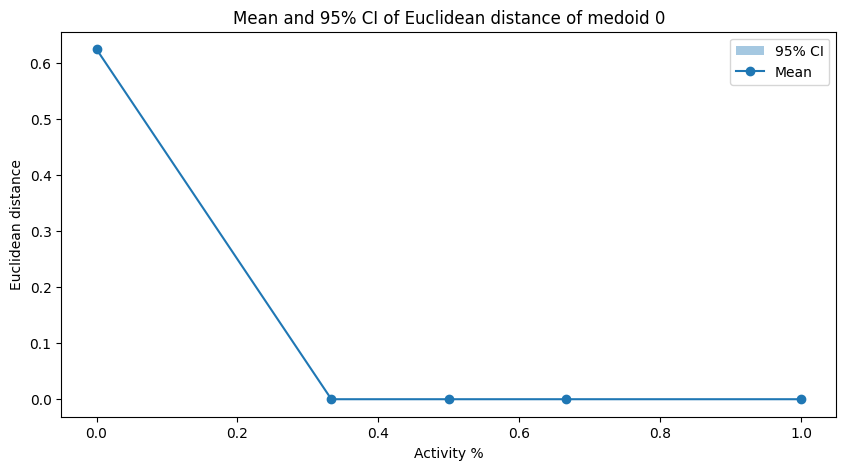

In [536]:
plot_medoid_distance(df_medoid_0, "Mean and 95% CI of Euclidean distance of medoid 0")

In [537]:
df_medoid_0['WorldSpace'].values[1]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,ra-world-shape ra-world-shapeA,', 'E,E,E,E,ra-world-shape ra-world-shapeA,false']"

In [538]:
df_medoid_0['WorldSpace'].values[2]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,ra-world-shape ra-world-shapeA,', 'E,E,E,E,ra-world-shape ra-world-shapeA,move1']"

In [539]:
df_medoid_0['WorldSpace'].values[-1]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,ra-world-shape ra-world-shapeA,', 'E,E,E,E,ra-world-shape ra-world-shapeA,false']"

In [541]:
df_medoid_7 = analysis_medoid(robotarm_l1_success, features, 7, initial_vector, key_vector_l1)
df_medoid_7

,Student ID,WorldSpace,index,euclidean_distance,index normalized
0,AUS128146,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.624695,0.0
1,AUS128146,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.624695,0.5
2,AUS128146,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.000000,1.0
3,AUS791208,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.624695,0.0
4,AUS791208,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.624695,0.5
5,AUS791208,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.000000,1.0
6,AUS891752,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.624695,0.0
7,AUS891752,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.624695,0.5
8,AUS891752,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.000000,1.0
9,BGR163111,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.624695,0.0


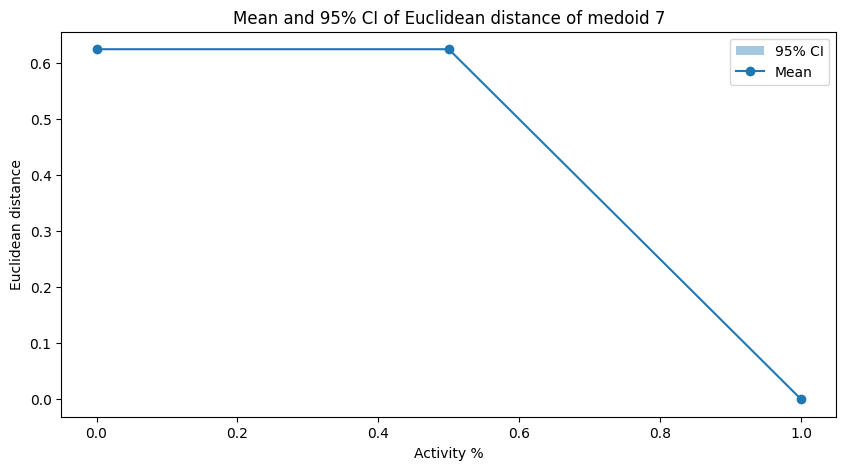

In [542]:
plot_medoid_distance(df_medoid_7, "Mean and 95% CI of Euclidean distance of medoid 7")

In [543]:
df_medoid_7['WorldSpace'].values[1]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,false']"

In [544]:
df_medoid_7['WorldSpace'].values[2]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,ra-world-shape ra-world-shapeA,', 'E,E,E,E,ra-world-shape ra-world-shapeA,false']"

In [545]:
df_medoid_33 = analysis_medoid(robotarm_l1_success, features, 33, initial_vector, key_vector_l1)
df_medoid_33

,Student ID,WorldSpace,index,euclidean_distance,index normalized
0,AUS123649,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.624695,0.000000
1,AUS123649,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.468521,0.333333
2,AUS123649,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.624695,0.666667
3,AUS123649,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",3,0.000000,1.000000
4,AUS214545,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.624695,0.000000
5,AUS214545,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.468521,0.333333
6,AUS214545,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.624695,0.666667
7,AUS214545,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",3,0.000000,1.000000
8,AUS214617,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.624695,0.000000
9,AUS214617,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.468521,0.333333


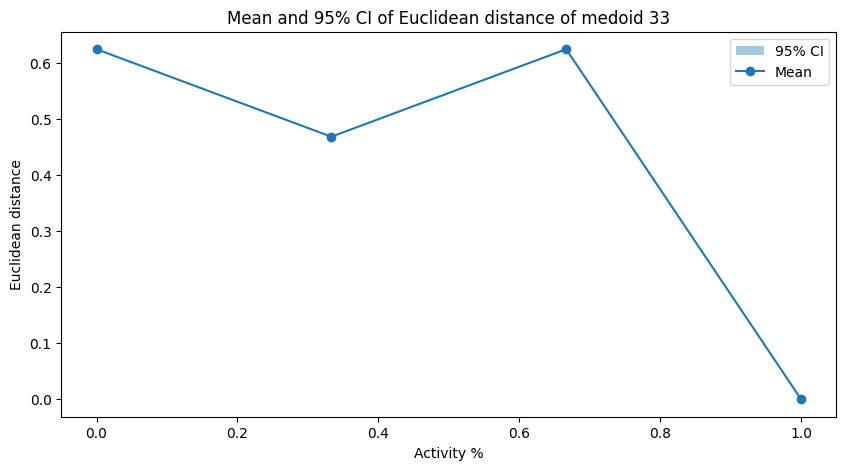

In [546]:
plot_medoid_distance(df_medoid_33, "Mean and 95% CI of Euclidean distance of medoid 33")

In [547]:
df_medoid_33['WorldSpace'].values[1]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,ra-world-shape ra-world-shapeA,E,E,E,', 'E,ra-world-shape ra-world-shapeA,E,E,E,false']"

In [548]:
df_medoid_33['WorldSpace'].values[2]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,pickup1']"

In [550]:
preprocess(df_medoid_33['WorldSpace'].values[2])

array([['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['A', 'E', 'E', 'E', 'E']], dtype='<U1')

### Learning task 2

In [565]:
import pandas as pd 

In [566]:
df = pd.read_csv("data/ldw_2023_pilot_coding_tasks_outputs_processed_2.csv")

In [567]:
robotarm_df = df[df['Activity Name'] == 'RobotArm']

In [568]:
robotarm_df['Activity ID'].unique()

array(['P1M120', 'P1M124', 'P1M123', 'P1M128'], dtype=object)

In [569]:
robotarm_df = df[df['Activity Name'] == 'RobotArm']
robotarm_l2 = robotarm_df[robotarm_df['Activity ID'] == "P1M123"]
key_vector_l2 = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,false']"

In [570]:
nb_student = len(robotarm_l2['Student ID'].unique())
print(f"Number of students: {nb_student}")

Number of students: 326


In [571]:
robotarm_l2_grouped = robotarm_l2.groupby('Student ID').apply(lambda x: 1 in x['WorldspaceScore'].values)

# separate the students into two groups
success_students_l2 = robotarm_l2_grouped[robotarm_l2_grouped == True].index
failure_students_l2 = robotarm_l2_grouped[robotarm_l2_grouped == False].index

In [572]:
robotarm_l2_success = robotarm_l2[robotarm_l2['Student ID'].isin(success_students_l2)]
robotarm_l2_failure = robotarm_l2[robotarm_l2['Student ID'].isin(failure_students_l2)]

In [573]:
# for each student, sort the rows by timestamp
robotarm_l2_success = robotarm_l2_success.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='timestamp')).reset_index(drop=True)
# drop rows where WorldSpace is Null
robotarm_l2_success = robotarm_l2_success.dropna(subset=['WorldSpace'])

robotarm_l2_success['index'] = robotarm_l2_success.groupby('Student ID').cumcount()

In [574]:
nb_student = len(robotarm_l2_success['Student ID'].unique())
print(f"Number of students: {nb_student}")

Number of students: 208


In [575]:
# compute the Euclidean distance between the key vector and the student's worldspace vector
from distances import * 

robotarm_l2_success['euclidean_distance'] = robotarm_l2_success['WorldSpace'].apply(lambda x: euclidean(x, key_vector_l2))

In [576]:
data = robotarm_l2_success[["Student ID", "WorldSpace", "index", "euclidean_distance"]]


# dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
index_dict = {i: i+1 for i in range(len(data['index'].unique()))}

data['index'] = data['index'].apply(lambda x: index_dict[x])

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_5601/3397285458.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['index'] = data['index'].apply(lambda x: index_dict[x])


In [577]:
initial_worldspace = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,false']"

key_vector_l2 = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,false']"

initial_distance = euclidean(initial_worldspace, key_vector_l2)

In [578]:
# for each student, add a new row with the initial worldspace and distance
initial_data = pd.DataFrame({'Student ID': data['Student ID'].unique(), 'WorldSpace': initial_worldspace, 'index': 0, 'euclidean_distance': initial_distance})

# append the initial data to the dataframe
data = pd.concat([data, initial_data])

# group the data by Student ID and sort by index
data = data.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

In [579]:
data['index normalized'] = data['index'] / data.groupby('Student ID')['index'].transform('max')

In [580]:
data.describe()

,index,euclidean_distance,index normalized
count,1430.000000,1430.000000,1430.000000
mean,4.358741,0.145632,0.500000
std,4.256881,0.089092,0.339707
min,0.000000,0.000000,0.000000
25%,1.000000,0.078087,0.200000
50%,3.000000,0.165647,0.500000
75%,6.000000,0.236779,0.800000
max,30.000000,0.468521,1.000000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


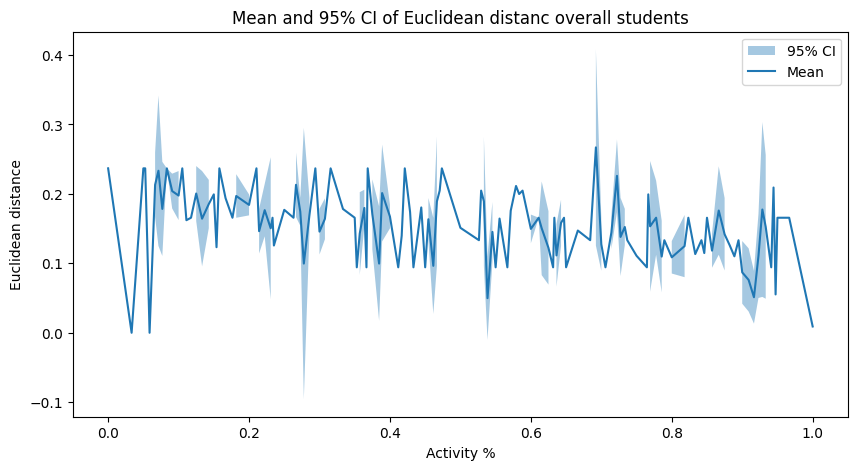

In [581]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# plot one figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))


grouped = data.groupby("index normalized")

# Calculate mean and 95% CI for "Jaro bars" metric
mean_values_bars = grouped["euclidean_distance"].mean()
ci_values_bars = grouped["euclidean_distance"].apply(lambda x: stats.sem(x, nan_policy='omit') * 1.96)  # 95% CI

# Fill between upper and lower CI
ax.fill_between(mean_values_bars.index, mean_values_bars - ci_values_bars, mean_values_bars + ci_values_bars, alpha=0.4, label="95% CI")

ax.plot(mean_values_bars.index, mean_values_bars, linestyle='-', label="Mean")
ax.set_xlabel("Activity %")
ax.set_ylabel("Euclidean distance")
ax.set_title("Mean and 95% CI of Euclidean distanc overall students")
ax.legend()

plt.show()

### Clustering

In [582]:
data = robotarm_l2_success[["Student ID", "index", "euclidean_distance"]]

pivot_data = data.pivot(index='Student ID', columns='index', values='euclidean_distance')

features = pivot_data.agg(['mean', 'std'], axis=1)

features.dropna(inplace=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

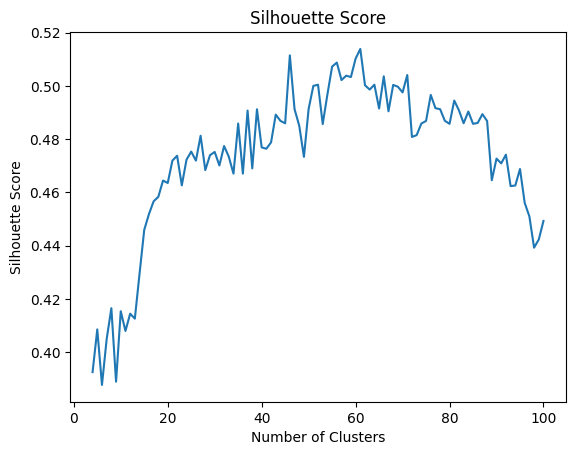

Optimal number of clusters based on silhouette score: 61


In [583]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)


max_clusters = 100

# Silhouette score
sil_scores = []
for i in range(4, max_clusters+1):
    kmeans = KMeans(n_clusters=i)
    cluster_labels = kmeans.fit_predict(normalized_features)
    sil_scores.append(silhouette_score(normalized_features, cluster_labels))

plt.plot(range(4, max_clusters+1), sil_scores)
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()
    
optimal_clusters_silhouette = np.argmax(sil_scores) + 4
print("Optimal number of clusters based on silhouette score:", optimal_clusters_silhouette)


In [584]:
optimal_kmeans = KMeans(n_clusters=optimal_clusters_silhouette)

cluster_labels = optimal_kmeans.fit_predict(normalized_features)

features['cluster'] = cluster_labels

features.reset_index(inplace=True)
features

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Student ID,mean,std,cluster
0,AUS123217,0.124658,0.095254,27
1,AUS123433,0.165136,0.085339,1
2,AUS123505,0.161112,0.083235,1
3,AUS123541,0.047130,0.066651,12
4,AUS123577,0.073621,0.084343,0
...,...,...,...,...
178,NOR951107,0.137359,0.077458,53
179,UK123001,0.151598,0.068705,16
180,UK123019,0.157901,0.078036,44
181,UK123022,0.151598,0.068705,16


### Find medoids

In [585]:
cluster_groups = features.groupby('cluster').agg({'Student ID': 'unique', 'mean': 'median', 'std': 'median'}).reset_index()

In [586]:
cluster_groups

,cluster,Student ID,mean,std
0,0,"[AUS123577, AUS416049, BGR214221, COL951143]",0.074830,0.084343
1,1,"[AUS123433, AUS123505, AUS214041, AUS821533, A...",0.165816,0.082561
2,2,"[AUS416085, NOR163111]",0.082824,0.117130
3,3,"[AUS512853, BGR214185, COL914141, NOR416013]",0.064266,0.044597
4,4,"[AUS128362, AUS951647, NOR163183]",0.126406,0.082824
...,...,...,...,...
56,56,"[AUS214805, UK123025]",0.139195,0.059007
57,57,"[AUS751170, BGR914213]",0.132193,0.098635
58,58,[AUS751242],0.091984,0.094521
59,59,"[AUS416661, COL821029]",0.160604,0.098299


In [587]:
student_medoids = []

for cluster in range(optimal_clusters_silhouette): 
    students = cluster_groups[cluster_groups['cluster'] == cluster]['Student ID'].values[0]
    print("Cluster : ", cluster)
    if len(students) == 1: 
        student_medoid = students[0]
        print(student_medoid)
    else:
        mean = cluster_groups[cluster_groups['cluster'] == cluster]['mean'].values[0]
        std = cluster_groups[cluster_groups['cluster'] == cluster]['std'].values[0]
        print(students)
        print(mean)
        print(std)
        
        student_index = find_student_medoid(features, students, mean, std)
        student_medoid = cluster_groups[cluster_groups['cluster'] == cluster]['Student ID'].values[0][student_index]
        print(student_medoid)
    student_medoids.append(student_medoid)


Cluster :  0
['AUS123577' 'AUS416049' 'BGR214221' 'COL951143']
0.07482997433623423
0.084343471224579
AUS123577
Cluster :  1
['AUS123433' 'AUS123505' 'AUS214041' 'AUS821533' 'AUS914573' 'COL128002']
0.16581579820275183
0.08256144020154849
AUS214041
Cluster :  2
['AUS416085' 'NOR163111']
0.08282364455613492
0.11713032141645456
AUS416085
Cluster :  3
['AUS512853' 'BGR214185' 'COL914141' 'NOR416013']
0.06426610861368637
0.044597417589781876
BGR214185
Cluster :  4
['AUS128362' 'AUS951647' 'NOR163183']
0.12640585332787724
0.08282364455613492
AUS128362
Cluster :  5
['AUS416373' 'AUS512737' 'AUS914609' 'BGR821245']
0.13274798075008992
0.12096293687169604
AUS512737
Cluster :  6
['AUS891716' 'BGR184040' 'NOR214077']
0.0
0.0
AUS891716
Cluster :  7
['AUS163183' 'AUS914069' 'BGR163219']
0.11838937675909768
0.16742786225361403
AUS163183
Cluster :  8
['AUS123757' 'AUS163651']
0.17699373471432997
0.11359916295708664
AUS123757
Cluster :  9
['AUS123685' 'AUS128542' 'BGR123073' 'COL163075' 'COL512053' 'N

In [588]:
features['student_medoid'] = np.nan

for cluster, medoid in enumerate(student_medoids):
    features.loc[features['cluster'] == cluster, 'student_medoid'] = medoid

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_5601/3087065301.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'AUS123577' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  features.loc[features['cluster'] == cluster, 'student_medoid'] = medoid


In [589]:
for idx, row in features.iterrows(): 
    student_id = row['Student ID']
    student_medoid = row['student_medoid']
    
    features.loc[idx, "distance_medoid"] = distance_to_medoid(features, student_id, student_medoid)

Graph with 183 nodes and 122 edges


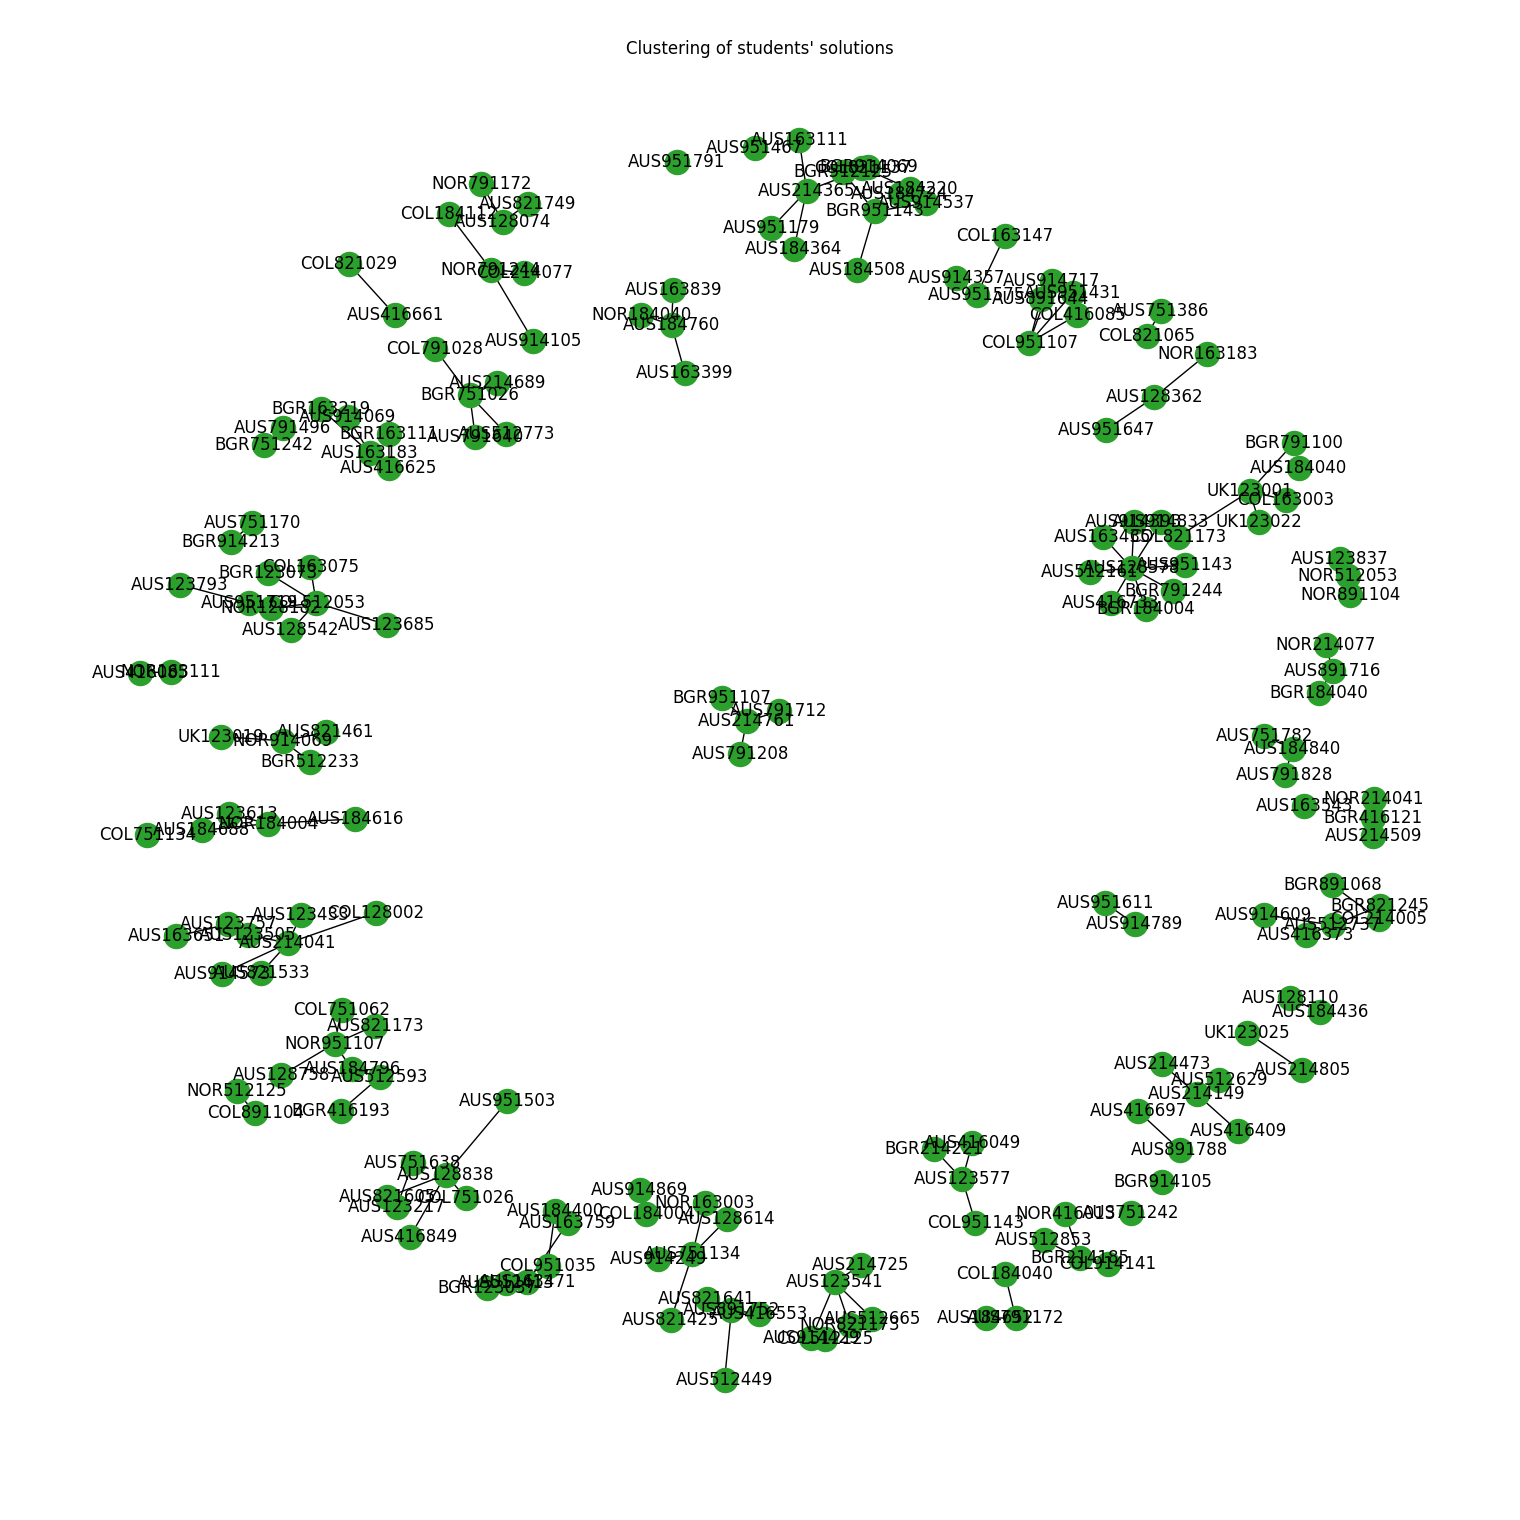

In [590]:
import networkx as nx
from itertools import combinations

G = nx.Graph()
edges = []
node_color = dict()
edges_length= dict()

for student in features['Student ID'].values:
    G.add_node(student)
    student_attr_medoid = features[features['Student ID'] == student]['student_medoid'].values[0]
    if student != student_attr_medoid:
        edges.append((student, student_attr_medoid))
        edges_length[(student, student_attr_medoid)] = (features[features['Student ID'] == student]['distance_medoid'].values[0])*0.001

G.add_edges_from(edges)
print(G)
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.13 )  # Seed layout for reproducibility seed=3929279
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color="tab:green",
)
plt.suptitle("Clustering of students' solutions")
plt.show()

In [591]:
# compute silhouette score for each medoid
sample_silhouette_values = silhouette_samples(normalized_features, cluster_labels)
silhouette_scores_clusters = []
for label in range(optimal_clusters_silhouette):
    silhouette_scores_clusters.append(sample_silhouette_values[cluster_labels == label].mean())


In [592]:
silhouette_df = pd.DataFrame({'cluster': range(optimal_clusters_silhouette), 'silhouette_score': silhouette_scores_clusters, 'nb_students': features.groupby('cluster').size()})

In [593]:
# remove rows with only one student
silhouette_df = silhouette_df[silhouette_df['nb_students'] > 1]

# sort the clusters by number of students
silhouette_df = silhouette_df.sort_values(by='nb_students', ascending=False)

# sort the clusters by silhouette score
silhouette_df = silhouette_df.sort_values(by='silhouette_score', ascending=False)
silhouette_df

,cluster,silhouette_score,nb_students
cluster,,,
11,11,1.000000,9
12,12,1.000000,5
7,7,1.000000,3
6,6,1.000000,3
38,38,1.000000,2
25,25,1.000000,4
31,31,1.000000,2
2,2,1.000000,2
17,17,1.000000,4


In [594]:
initial_worldspace = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,false']"

#### Analysis of medoids

In [595]:
df_medoid_11 = analysis_medoid(robotarm_l2_success, features, 11, initial_worldspace=initial_worldspace, key_vector=key_vector_l2)
df_medoid_11

,Student ID,WorldSpace,index,euclidean_distance,index normalized
0,AUS128578,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-sha...",0,0.236779,0.0
1,AUS128578,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.199300,0.5
2,AUS128578,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.000000,1.0
3,AUS163435,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-sha...",0,0.236779,0.0
4,AUS163435,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.199300,0.5
5,AUS163435,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.000000,1.0
6,AUS416733,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-sha...",0,0.236779,0.0
7,AUS416733,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.199300,0.5
8,AUS416733,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.000000,1.0
9,AUS512161,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-sha...",0,0.236779,0.0


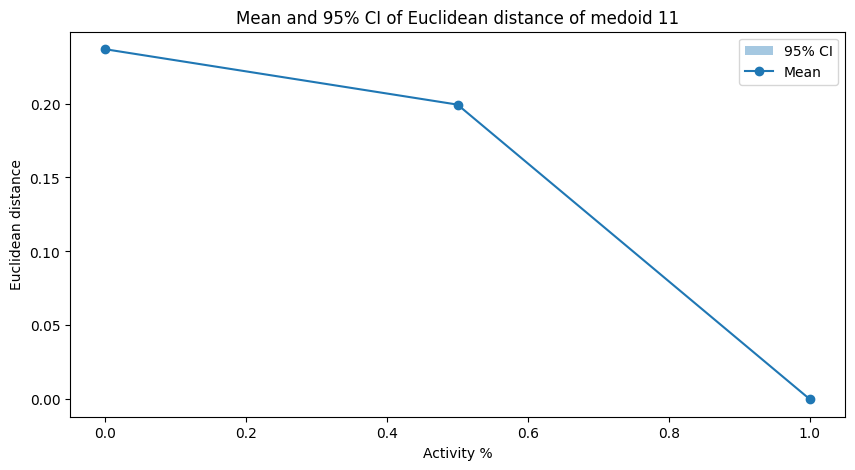

In [596]:
plot_medoid_distance(df_medoid_11, "Mean and 95% CI of Euclidean distance of medoid 11")

In [597]:
mediate_vector = df_medoid_11['WorldSpace'].values[1]

In [598]:
mediate_vector

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,move1']"

In [599]:
df_medoid_12 = analysis_medoid(robotarm_l2_success, features, 12, initial_worldspace=mediate_vector, key_vector=key_vector_l2)

In [600]:
df_medoid_12

,Student ID,WorldSpace,index,euclidean_distance,index normalized
0,AUS123541,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.199300,0.0
1,AUS123541,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.094259,0.5
2,AUS123541,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.000000,1.0
3,AUS214725,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.199300,0.0
4,AUS214725,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.094259,0.5
5,AUS214725,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.000000,1.0
6,AUS512665,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.199300,0.0
7,AUS512665,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.094259,0.5
8,AUS512665,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.000000,1.0
9,AUS914429,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.199300,0.0


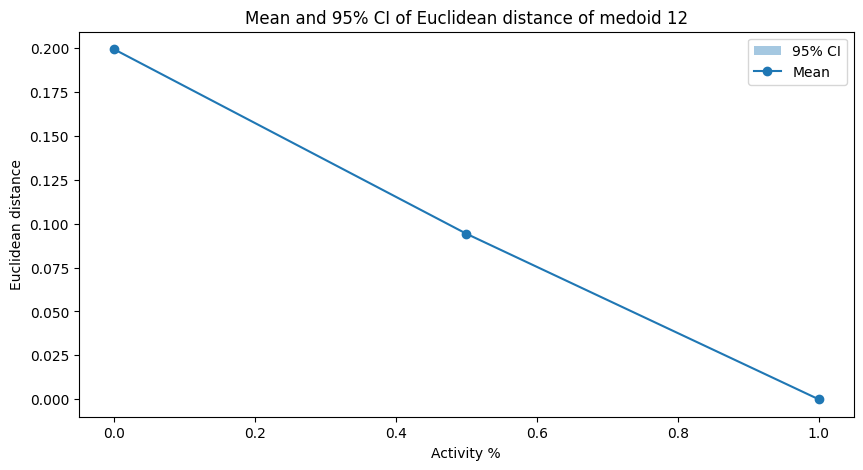

In [601]:
plot_medoid_distance(df_medoid_12, "Mean and 95% CI of Euclidean distance of medoid 12")

In [602]:
preprocess(df_medoid_12['WorldSpace'].values[1])

array([['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'A', 'E', 'E'],
       ['E', 'B', 'B', 'A', 'E']], dtype='<U1')

In [336]:
df_medoid_8 = analysis_medoid(robotarm_l2_success, features, 8, initial_worldspace=mediate_vector, key_vector=key_vector_l2)

In [337]:
df_medoid_8

,Student ID,WorldSpace,index,euclidean_distance,index normalized
0,AUS214149,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.199300,0.000000
1,AUS214149,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-sha...",1,0.236779,0.333333
2,AUS214149,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.199300,0.666667
3,AUS214149,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",3,0.000000,1.000000
4,AUS214473,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.199300,0.000000
5,AUS214473,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-sha...",1,0.236779,0.333333
6,AUS214473,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.199300,0.666667
7,AUS214473,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",3,0.000000,1.000000
8,AUS416409,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.199300,0.000000
9,AUS416409,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-sha...",1,0.236779,0.333333


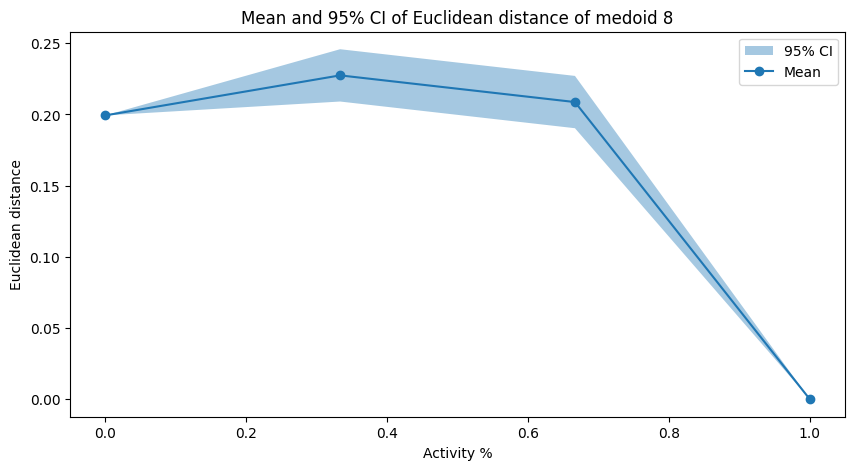

In [338]:
plot_medoid_distance(df_medoid_8, "Mean and 95% CI of Euclidean distance of medoid 8")

In [341]:
df_medoid_8['WorldSpace'].values[1]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,place1']"

In [340]:
preprocess(df_medoid_8['WorldSpace'].values[1])

array([['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'B', 'E', 'E'],
       ['E', 'E', 'A', 'E', 'E'],
       ['E', 'E', 'A', 'E', 'E'],
       ['E', 'E', 'B', 'E', 'E']], dtype='<U1')

In [342]:
df_medoid_8['WorldSpace'].values[2]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,move1']"

In [343]:
preprocess(df_medoid_8['WorldSpace'].values[2])

array([['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'A', 'E', 'E'],
       ['E', 'E', 'A', 'E', 'E'],
       ['E', 'E', 'B', 'E', 'E']], dtype='<U1')

### Learning Task 3

In [604]:
import pandas as pd 

df = pd.read_csv("data/ldw_2023_pilot_coding_tasks_outputs_processed_2.csv")
robotarm_df = df[df['Activity Name'] == 'RobotArm']

robotarm_df = df[df['Activity Name'] == 'RobotArm']
robotarm_l3 = robotarm_df[robotarm_df['Activity ID'] == "P1M124"]
key_vector_l3 = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,false']"
initial_worldspace = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeA,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,false']"

### Overview

In [607]:
robotarm_l3_grouped = robotarm_l3.groupby('Student ID').apply(lambda x: 1 in x['WorldspaceScore'].values)

# separate the students into two groups
success_students_l3 = robotarm_l3_grouped[robotarm_l3_grouped == True].index
failure_students_l3 = robotarm_l3_grouped[robotarm_l3_grouped == False].index

In [608]:
robotarm_l3_success = robotarm_l3[robotarm_l3['Student ID'].isin(success_students_l3)]
robotarm_l3_failure = robotarm_l3[robotarm_l3['Student ID'].isin(failure_students_l3)]

In [609]:
# for each student, sort the rows by timestamp
robotarm_l3_success = robotarm_l3_success.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='timestamp')).reset_index(drop=True)
# drop rows where WorldSpace is Null
robotarm_l3_success = robotarm_l3_success.dropna(subset=['WorldSpace'])

robotarm_l3_success['index'] = robotarm_l3_success.groupby('Student ID').cumcount()

In [610]:
total_students_l3 = len(robotarm_l3['Student ID'].unique())
print(f"Number of students who attempted the task: {total_students_l3}")

Number of students who attempted the task: 245


In [611]:
nb_student = len(robotarm_l3_success['Student ID'].unique())
print(f"Number of students: {nb_student}")

Number of students: 109


In [612]:
# compute the Euclidean distance between the key vector and the student's worldspace vector
from distances import * 

robotarm_l3_success['euclidean_distance'] = robotarm_l3_success['WorldSpace'].apply(lambda x: euclidean(x, key_vector_l3))

In [617]:
data = robotarm_l3_success[["Student ID", "WorldSpace", "index", "euclidean_distance"]]

initial_distance = euclidean(initial_worldspace, key_vector_l3)

# dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
index_dict = {i: i+1 for i in range(len(data['index'].unique()))}

data['index'] = data['index'].apply(lambda x: index_dict[x])

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_5601/2940217732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['index'] = data['index'].apply(lambda x: index_dict[x])


In [618]:
# for each student, add a new row with the initial worldspace and distance
initial_data = pd.DataFrame({'Student ID': data['Student ID'].unique(), 'WorldSpace': initial_worldspace, 'index': 0, 'euclidean_distance': initial_distance})

# append the initial data to the dataframe
data = pd.concat([data, initial_data])

# group the data by Student ID and sort by index
data = data.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

In [619]:
data['index normalized'] = data['index'] / data.groupby('Student ID')['index'].transform('max')

In [620]:
data.describe()

,index,euclidean_distance,index normalized
count,650.000000,650.000000,650.000000
mean,3.027692,0.110739,0.500000
std,2.624262,0.074410,0.344491
min,0.000000,0.000000,0.000000
25%,1.000000,0.044173,0.200000
50%,2.000000,0.119477,0.500000
75%,4.000000,0.145250,0.800000
max,13.000000,0.468521,1.000000


In [422]:
data = robotarm_l3_success[["Student ID", "index", "euclidean_distance"]]

pivot_data = data.pivot(index='Student ID', columns='index', values='euclidean_distance')

features = pivot_data.agg(['mean', 'std'], axis=1)

features.dropna(inplace=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

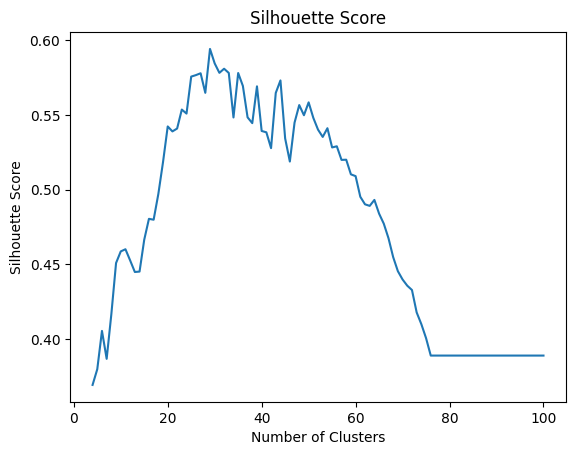

Optimal number of clusters based on silhouette score: 29


In [423]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)


max_clusters = 100

# Silhouette score
sil_scores = []
for i in range(4, max_clusters+1):
    kmeans = KMeans(n_clusters=i)
    cluster_labels = kmeans.fit_predict(normalized_features)
    sil_scores.append(silhouette_score(normalized_features, cluster_labels))

plt.plot(range(4, max_clusters+1), sil_scores)
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()
    
optimal_clusters_silhouette = np.argmax(sil_scores) + 4
print("Optimal number of clusters based on silhouette score:", optimal_clusters_silhouette)


In [424]:
optimal_kmeans = KMeans(n_clusters=optimal_clusters_silhouette)

cluster_labels = optimal_kmeans.fit_predict(normalized_features)

features['cluster'] = cluster_labels

features.reset_index(inplace=True)
features

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Student ID,mean,std,cluster
0,AUS123109,0.096834,0.083860,11
1,AUS123505,0.148742,0.064527,13
2,AUS123613,0.112172,0.080928,27
3,AUS123757,0.050539,0.071473,21
4,AUS123837,0.069522,0.058807,15
...,...,...,...,...
103,NOR821245,0.112473,0.078907,27
104,NOR914213,0.116764,0.081578,27
105,NOR914249,0.072625,0.102708,1
106,UK123010,0.089738,0.064965,0


In [425]:
cluster_groups = features.groupby('cluster').agg({'Student ID': 'unique', 'mean': 'median', 'std': 'median'}).reset_index()
cluster_groups

,cluster,Student ID,mean,std
0,0,"[AUS128614, AUS128650, AUS416733, AUS512377, A...",0.090960,0.063562
1,1,"[AUS214149, AUS214617, AUS214653, AUS751638, A...",0.072625,0.102708
2,2,"[AUS184364, BGR914213]",0.123840,0.082237
3,3,"[AUS416445, AUS512053, AUS512593, AUS791100, B...",0.075860,0.065903
4,4,[AUS214797],0.000000,0.000000
5,5,[AUS128794],0.091533,0.155023
6,6,"[AUS914681, BGR951143]",0.106163,0.054834
7,7,"[AUS416849, AUS512629, NOR214041, NOR214185]",0.063430,0.060144
8,8,"[AUS214113, AUS214473, AUS914429, COL416157, C...",0.063141,0.074460
9,9,[AUS512197],0.027608,0.039043


In [426]:
student_medoids = []

for cluster in range(optimal_clusters_silhouette): 
    students = cluster_groups[cluster_groups['cluster'] == cluster]['Student ID'].values[0]
    print("Cluster : ", cluster)
    if len(students) == 1: 
        student_medoid = students[0]
        print(student_medoid)
    else:
        mean = cluster_groups[cluster_groups['cluster'] == cluster]['mean'].values[0]
        std = cluster_groups[cluster_groups['cluster'] == cluster]['std'].values[0]
        print(students)
        print(mean)
        print(std)
        
        student_index = find_student_medoid(features, students, mean, std)
        student_medoid = cluster_groups[cluster_groups['cluster'] == cluster]['Student ID'].values[0][student_index]
        print(student_medoid)
    student_medoids.append(student_medoid)


Cluster :  0
['AUS128614' 'AUS128650' 'AUS416733' 'AUS512377' 'AUS751242' 'COL416085'
 'COL891068' 'UK123010']
0.09095951671200393
0.06356218389274917
AUS751242
Cluster :  1
['AUS214149' 'AUS214617' 'AUS214653' 'AUS751638' 'AUS791064' 'AUS914717'
 'AUS951683' 'AUS951791' 'NOR184040' 'NOR914249']
0.07262519619230882
0.10270753742517001
AUS214149
Cluster :  2
['AUS184364' 'BGR914213']
0.12383973782367627
0.08223685506232992
BGR914213
Cluster :  3
['AUS416445' 'AUS512053' 'AUS512593' 'AUS791100' 'BGR214221' 'COL791028'
 'COL821137']
0.07585966070536318
0.06590323633158802
AUS512053
Cluster :  4
AUS214797
Cluster :  5
AUS128794
Cluster :  6
['AUS914681' 'BGR951143']
0.10616328386213164
0.05483389686652439
AUS914681
Cluster :  7
['AUS416849' 'AUS512629' 'NOR214041' 'NOR214185']
0.06342969517389824
0.06014406761190756
AUS512629
Cluster :  8
['AUS214113' 'AUS214473' 'AUS914429' 'COL416157' 'COL751062' 'NOR163183'
 'NOR821173']
0.06314100093818542
0.0744598482460605
AUS214473
Cluster :  9
AUS5

In [427]:
features['student_medoid'] = np.nan

for cluster, medoid in enumerate(student_medoids):
    features.loc[features['cluster'] == cluster, 'student_medoid'] = medoid

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_5601/3087065301.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'AUS751242' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  features.loc[features['cluster'] == cluster, 'student_medoid'] = medoid


In [428]:
for idx, row in features.iterrows(): 
    student_id = row['Student ID']
    student_medoid = row['student_medoid']
    
    features.loc[idx, "distance_medoid"] = distance_to_medoid(features, student_id, student_medoid)

Graph with 108 nodes and 79 edges


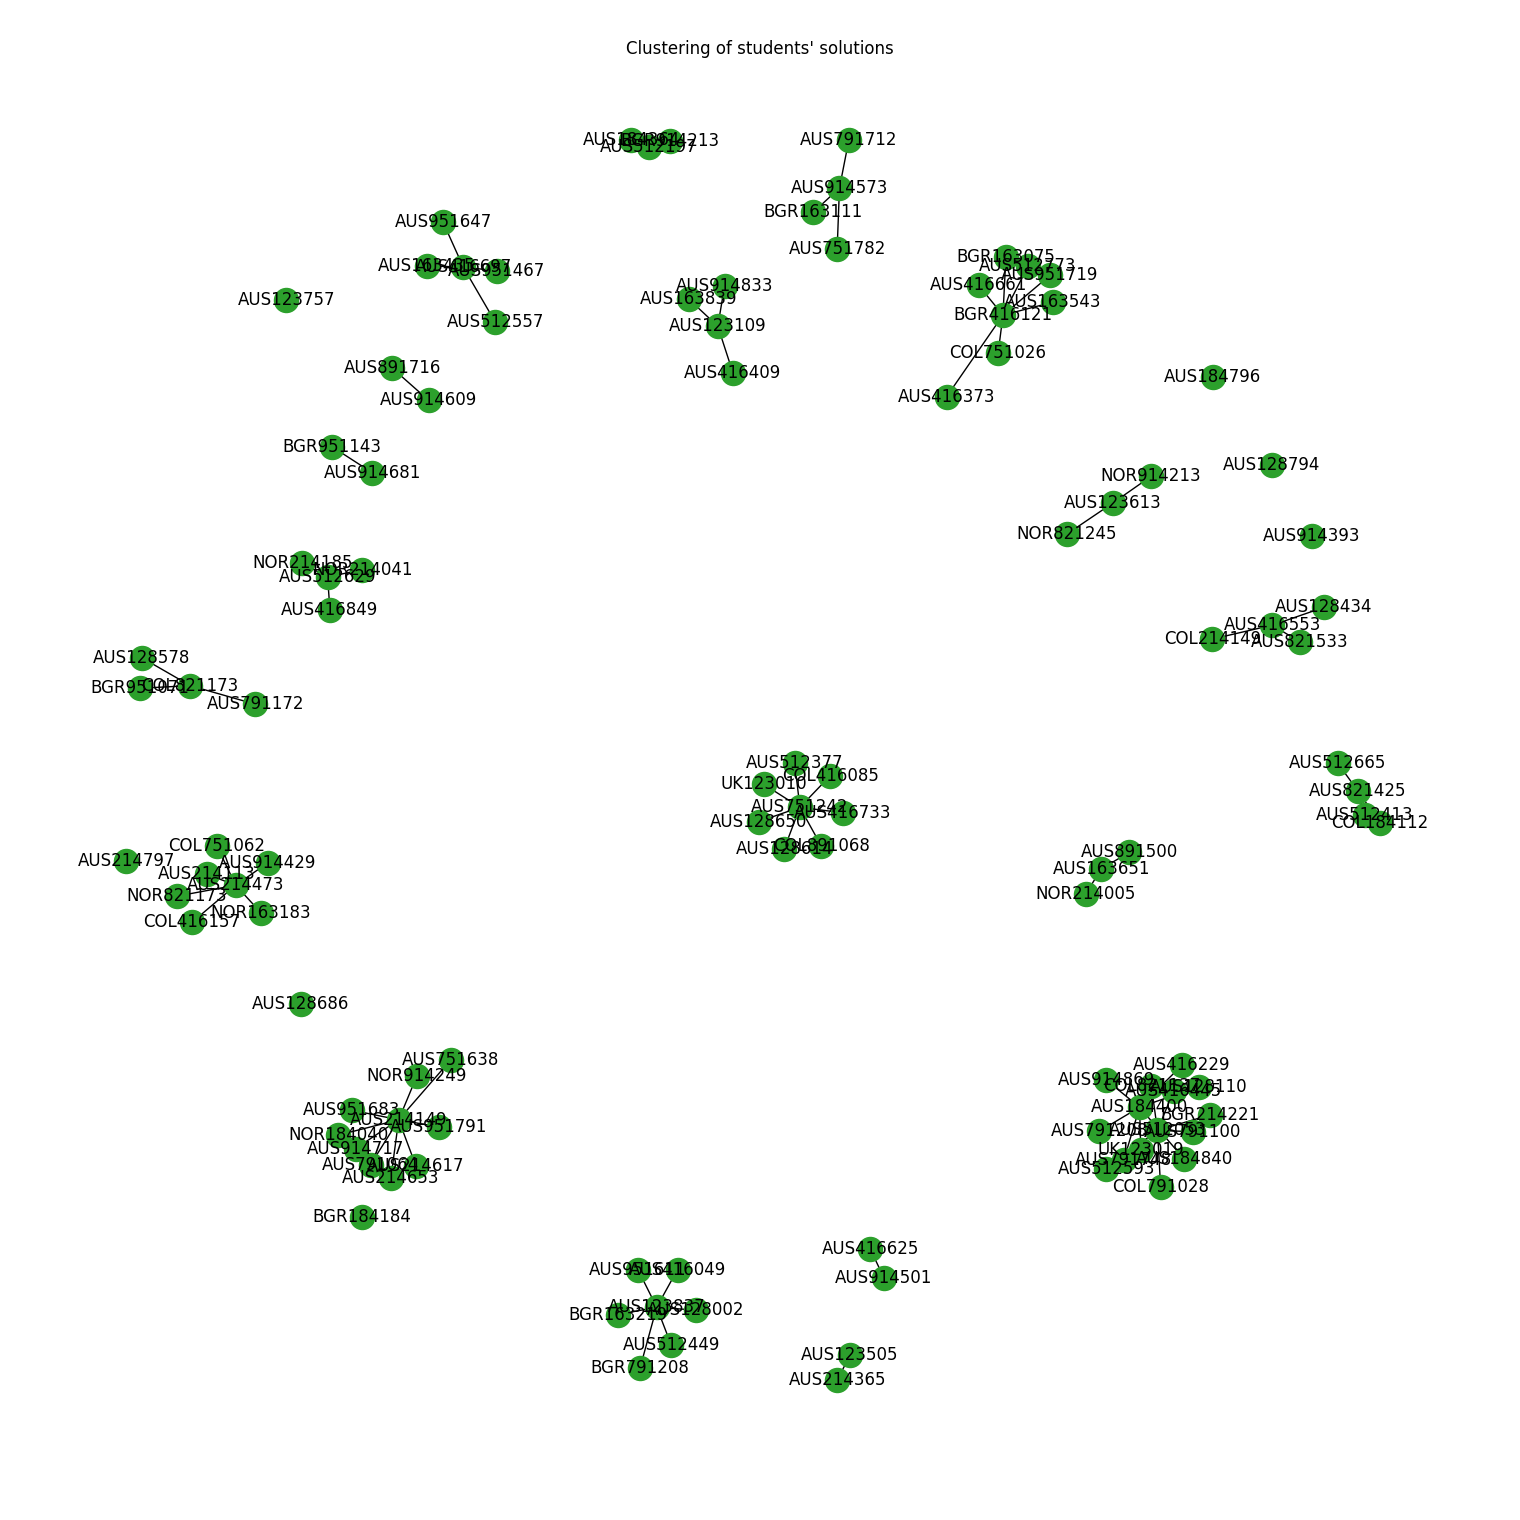

In [429]:
import networkx as nx
from itertools import combinations

G = nx.Graph()
edges = []
node_color = dict()
edges_length= dict()

for student in features['Student ID'].values:
    G.add_node(student)
    student_attr_medoid = features[features['Student ID'] == student]['student_medoid'].values[0]
    if student != student_attr_medoid:
        edges.append((student, student_attr_medoid))
        edges_length[(student, student_attr_medoid)] = (features[features['Student ID'] == student]['distance_medoid'].values[0])*0.001

G.add_edges_from(edges)
print(G)
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.13 )  # Seed layout for reproducibility seed=3929279
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color="tab:green",
)
plt.suptitle("Clustering of students' solutions")
plt.show()

In [430]:
# compute silhouette score for each medoid
sample_silhouette_values = silhouette_samples(normalized_features, cluster_labels)
silhouette_scores_clusters = []
for label in range(optimal_clusters_silhouette):
    silhouette_scores_clusters.append(sample_silhouette_values[cluster_labels == label].mean())


In [431]:
silhouette_df = pd.DataFrame({'cluster': range(optimal_clusters_silhouette), 'silhouette_score': silhouette_scores_clusters, 'nb_students': features.groupby('cluster').size()})

In [432]:
# remove rows with only one student
silhouette_df = silhouette_df[silhouette_df['nb_students'] > 1]

# sort the clusters by number of students
silhouette_df = silhouette_df.sort_values(by='nb_students', ascending=False)

# sort the clusters by silhouette score
silhouette_df = silhouette_df.sort_values(by='silhouette_score', ascending=False)
silhouette_df

,cluster,silhouette_score,nb_students
cluster,,,
1,1,1.000000,10
11,11,1.000000,4
19,19,1.000000,2
6,6,0.867654,2
8,8,0.857030,7
14,14,0.761659,8
3,3,0.735202,7
18,18,0.694733,3
23,23,0.678075,2


In [433]:
initial_worldspace = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeA,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,false']"

In [434]:
preprocess(initial_worldspace)

array([['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'B', 'E', 'E'],
       ['E', 'A', 'A', 'E', 'E'],
       ['E', 'A', 'B', 'E', 'E']], dtype='<U1')

### Analysis of medoids

In [435]:
df_medoid_1 = analysis_medoid(robotarm_l3_success, features, 1, initial_worldspace=initial_worldspace, key_vector=key_vector_l3)
df_medoid_1

,Student ID,WorldSpace,index,euclidean_distance,index normalized
0,AUS214149,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.20772,0.0
1,AUS214149,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.14525,0.5
2,AUS214149,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra...",2,0.00000,1.0
3,AUS214617,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.20772,0.0
4,AUS214617,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.14525,0.5
5,AUS214617,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra...",2,0.00000,1.0
6,AUS214653,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.20772,0.0
7,AUS214653,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.14525,0.5
8,AUS214653,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra...",2,0.00000,1.0
9,AUS751638,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.20772,0.0


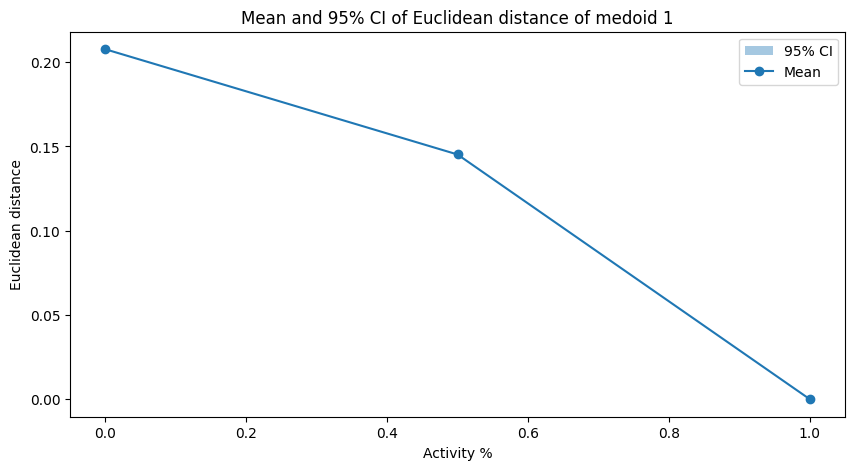

In [436]:
plot_medoid_distance(df_medoid_1, "Mean and 95% CI of Euclidean distance of medoid 1")

In [438]:
df_medoid_1['WorldSpace'].values[1]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'ra-world-shape ra-world-shapeA,E,ra-world-shape ra-world-shapeA,E,E,', 'ra-world-shape ra-world-shapeA,E,ra-world-shape ra-world-shapeB,E,E,false']"

In [439]:
preprocess(df_medoid_1['WorldSpace'].values[1])

array([['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'B', 'E', 'E'],
       ['A', 'E', 'A', 'E', 'E'],
       ['A', 'E', 'B', 'E', 'E']], dtype='<U1')

In [459]:
df_medoid_8 = analysis_medoid(robotarm_l3_success, features, 8, initial_worldspace=initial_worldspace, key_vector=key_vector_l3)

In [460]:
df_medoid_8

,Student ID,WorldSpace,index,euclidean_distance,index normalized
0,AUS214113,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.207720,0.000000
1,AUS214113,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.145250,0.333333
2,AUS214113,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",2,0.055216,0.666667
3,AUS214113,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra...",3,0.000000,1.000000
4,AUS214473,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.207720,0.000000
5,AUS214473,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.145250,0.333333
6,AUS214473,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra...",2,0.044173,0.666667
7,AUS214473,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra...",3,0.000000,1.000000
8,AUS914429,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.207720,0.000000
9,AUS914429,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",1,0.145250,0.333333


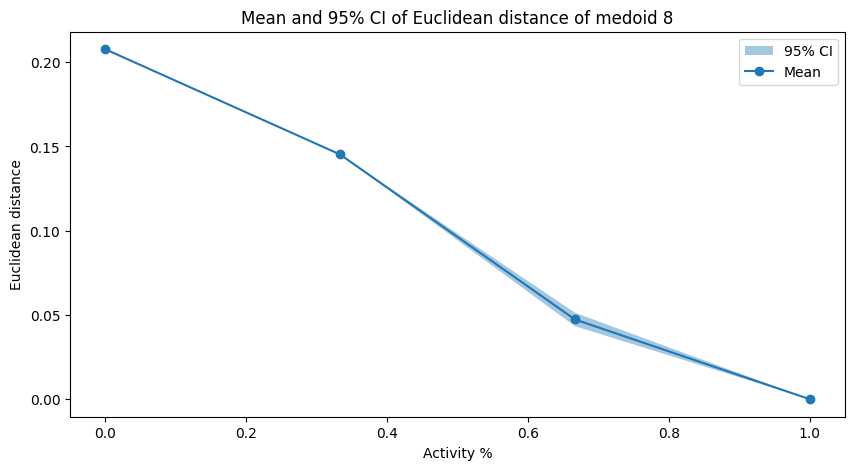

In [461]:
plot_medoid_distance(df_medoid_8, "Mean and 95% CI of Euclidean distance of medoid 8")

In [462]:
df_medoid_8['WorldSpace'].values[1]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'ra-world-shape ra-world-shapeA,E,ra-world-shape ra-world-shapeA,E,E,', 'ra-world-shape ra-world-shapeA,E,ra-world-shape ra-world-shapeB,E,E,false']"

In [463]:
preprocess(df_medoid_8['WorldSpace'].values[1])

array([['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'B', 'E', 'E'],
       ['A', 'E', 'A', 'E', 'E'],
       ['A', 'E', 'B', 'E', 'E']], dtype='<U1')

In [464]:
df_medoid_8['WorldSpace'].values[2]

"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,ra-world-shape ra-world-shapeB,E,E,false']"

In [465]:
preprocess(df_medoid_8['WorldSpace'].values[2])

array([['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['A', 'E', 'E', 'E', 'E'],
       ['A', 'B', 'B', 'E', 'E']], dtype='<U1')

In [466]:
preprocess(df_medoid_8['WorldSpace'].values[0])

array([['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'B', 'E', 'E'],
       ['E', 'A', 'A', 'E', 'E'],
       ['E', 'A', 'B', 'E', 'E']], dtype='<U1')